In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

# os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=0'
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import time


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
from tensorflow.keras.backend import clear_session
clear_session()

import keras
from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, SpatialDropout2D, Activation, Flatten,Dropout, GlobalAveragePooling2D
from keras.models import Model,Sequential
from keras.utils import model_to_dot, plot_model

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report, accuracy_score,precision_score,recall_score,f1_score
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

2024-06-04 08:51:54.639827: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 08:51:54.639886: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 08:51:54.640970: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
with open('dataset.pickle', 'rb') as data:
    dataset = pickle.load(data)

In [3]:
x_data, y_data = dataset

# print(len(x_data))
# print(len(x_data[0]))
# print(len(x_data[0][0]))
# print(len(x_data[0][0][0]))

# print(x_data[1].shape)


for x in range(len(x_data)-1):
    #print(x)
    if not x_data[x].shape == (128, 128, 3):
        del x_data[x]
        y_data = np.delete(y_data, x)
        #print(x)

x_array = np.array(x_data)
y_array = np.array(y_data)

print(x_array.shape)
print(y_array.shape)

(9999, 128, 128, 3)
(9999,)


In [4]:

def create_train_test_splits(x_array, y_array, train_slices, test_slices):
    """
    Create training and testing datasets based on provided slices.

    Parameters:
    - x_array: numpy array of features.
    - y_array: numpy array of labels.
    - train_slices: list of tuples, each specifying a slice for training data.
    - test_slices: list of tuples, each specifying a slice for testing data.

    Returns:
    - x_train, y_train: numpy arrays for training features and labels.
    - x_test, y_test: numpy arrays for testing features and labels.
    """
    x_train = np.concatenate([x_array[start:end] for start, end in train_slices], axis=0)
    y_train = np.concatenate([y_array[start:end] for start, end in train_slices], axis=0)
    x_test = np.concatenate([x_array[start:end] for start, end in test_slices], axis=0)
    y_test = np.concatenate([y_array[start:end] for start, end in test_slices], axis=0)
    
    return x_train, y_train, x_test, y_test

# Define slices for training and testing
train_slices = [(0, 799), (1000, 1799), (2000, 2799), (3000, 3799), 
                (4000, 4799), (5000, 5799), (6000, 6799), (7000, 7799), 
                (8000, 8799), (9000, 9799)]

test_slices = [(800, 999), (1800, 1999), (2800, 2999), (3800, 3999), 
               (4800, 4999), (5800, 5999), (6800, 6999), (7800, 7999), 
               (8800, 8999), (9800, 9999)]

x_train, y_train, x_test, y_test = create_train_test_splits(x_array, y_array, train_slices, test_slices)

x_array = []
y_array = []


In [5]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(7990, 128, 128, 3)
(7990,)
(1990, 128, 128, 3)
(1990,)


In [6]:
# Normalize the image data
x_train = x_train / 255.0
x_test = x_test / 255.0

In [7]:
#Constant
bs = 64
lr = 0.0001
size = (128, 128)

shape = (128,128, 3) 
epochs = 10
class_number = 10


In [8]:
mobile_base = MobileNetV2(
    input_shape=(128,128,3),
    include_top=False,
    weights='imagenet'
)


inputs = Input(shape=(128,128,3))
#--> Freezing the model parameters

for layer in mobile_base.layers[:-10]:
    layer.trainable = False
for layer in mobile_base.layers:
    print(layer, layer.trainable)

x = mobile_base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)    
x = Flatten()(x)
x = Dense(units=1024, activation="relu")(x)
x = Dropout(0.5)(x) 
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x) 
x = Dense(50, activation='relu')(x)
outputs = Dense(class_number, activation='softmax')(x)

<InputLayer name=input_layer, built=True> False
<Conv2D name=Conv1, built=True> False
<BatchNormalization name=bn_Conv1, built=True> False
<ReLU name=Conv1_relu, built=True> False
<DepthwiseConv2D name=expanded_conv_depthwise, built=True> False
<BatchNormalization name=expanded_conv_depthwise_BN, built=True> False
<ReLU name=expanded_conv_depthwise_relu, built=True> False
<Conv2D name=expanded_conv_project, built=True> False
<BatchNormalization name=expanded_conv_project_BN, built=True> False
<Conv2D name=block_1_expand, built=True> False
<BatchNormalization name=block_1_expand_BN, built=True> False
<ReLU name=block_1_expand_relu, built=True> False
<ZeroPadding2D name=block_1_pad, built=True> False
<DepthwiseConv2D name=block_1_depthwise, built=True> False
<BatchNormalization name=block_1_depthwise_BN, built=True> False
<ReLU name=block_1_depthwise_relu, built=True> False
<Conv2D name=block_1_project, built=True> False
<BatchNormalization name=block_1_project_BN, built=True> False
<Con

In [9]:
model_m1 = Model(inputs=inputs, outputs=outputs)

model_m1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50)             │        12,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,239,216 (16.17 MB)

 Trainable params: 2,713,712 (10.35 MB)

 Non-trainable params: 1,525,504 (5.82 MB)

In [10]:
for layer in model_m1.layers:
    print(layer, layer.trainable)

<InputLayer name=input_layer_1, built=True> True
<Functional name=mobilenetv2_1.00_128, built=True> True
<GlobalAveragePooling2D name=global_average_pooling2d, built=True> True
<Dropout name=dropout, built=True> True
<Flatten name=flatten, built=True> True
<Dense name=dense, built=True> True
<Dropout name=dropout_1, built=True> True
<Dense name=dense_1, built=True> True
<Dropout name=dropout_2, built=True> True
<Dense name=dense_2, built=True> True
<Dropout name=dropout_3, built=True> True
<Dense name=dense_3, built=True> True
<Dense name=dense_4, built=True> True


In [11]:
model_m1.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)


In [12]:
start_time = time.time()
print("batch_size :",bs)
# Train the model
history = model_m1.fit(
    x_train,
    y_train,
    batch_size= bs,
    epochs=20,
    verbose=1,
    #callbacks=callback_list,
    validation_data=(x_test, y_test)
)
cnn_train_time = time.time() - start_time

batch_size : 64
Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 466ms/step - accuracy: 0.1943 - loss: 2.3062 - val_accuracy: 0.4854 - val_loss: 1.8144
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 449ms/step - accuracy: 0.5199 - loss: 1.3151 - val_accuracy: 0.4296 - val_loss: 2.6857
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 448ms/step - accuracy: 0.6655 - loss: 1.0237 - val_accuracy: 0.4156 - val_loss: 2.9498
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 449ms/step - accuracy: 0.6953 - loss: 0.9463 - val_accuracy: 0.5317 - val_loss: 3.2274
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 447ms/step - accuracy: 0.7403 - loss: 0.8161 - val_accuracy: 0.5925 - val_loss: 1.7442
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 448ms/step - accuracy: 0.7686 - loss: 0.7647 - val_accuracy: 0.5141 - val_loss: 2.6357
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 448ms/step - accuracy: 0.7743 - loss: 0.6981 - val_accuracy: 0.5824 - val_loss: 2.2443
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 447ms/step - accuracy: 

In [27]:
# model_m1.save('model/my_model_A.keras')
print(cnn_train_time)

11.556419849395752


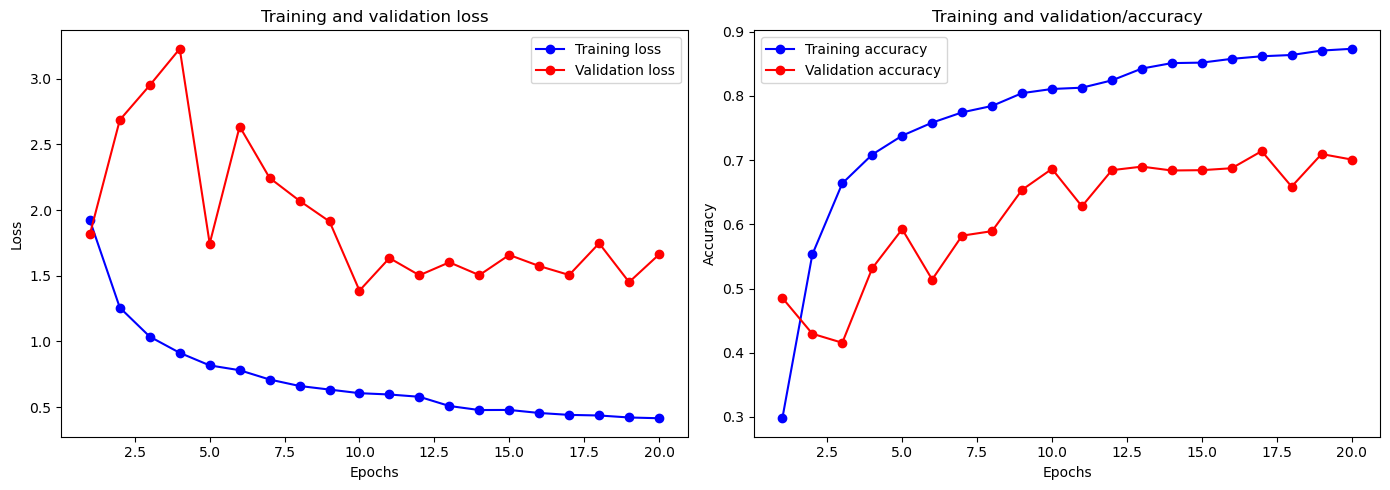

In [14]:
def plot_loss_and_accuracy(history):
    """
    Plots the loss and accuracy from the training history.
    
    Parameters:
    history: History object returned by the `fit` method of a Keras model.
    """
    # Get the loss and accuracy values from the history object
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(1, len(loss) + 1)
    
    # Plot loss
    plt.figure(figsize=(14, 5))
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
    plt.title('Training and validation/accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
plot_loss_and_accuracy(history)

In [15]:
start_time = time.time()
y_pred = np.argmax(model_m1.predict(x_test), axis=1)
cnn_train_time = time.time() - start_time

63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step


In [16]:

# Calculate classification metrics
classification_accuracy = accuracy_score(y_test, y_pred)
classification_precision = precision_score(y_test, y_pred, average='weighted')
classification_recall = recall_score(y_test, y_pred, average='weighted')
classification_f1 = f1_score(y_test, y_pred, average='weighted')

In [17]:
y_pred_test = model_m1.predict(x_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step


Classification Metrics:
Accuracy: 0.7010050251256281
Precision: 0.7224176576320558
Recall: 0.7010050251256281
F1-Score: 0.695608754038771
Confusion Matrix:
[[140   9   4   0   9   7   4   1   8  17]
 [  7 125   1   4   9  11   8  11  11  12]
 [ 12   8 148   0   7   2   3   3   7   9]
 [  2   8   0 132   4   1   7  14  12  19]
 [  1   3   0   3 150   4  10   6  10  12]
 [ 26  59   1   2  14  61   7   3   8  18]
 [  0   2   0   1   0   1 184   7   3   1]
 [  1   1   0   0   0   1   5 136  42  13]
 [  0   1   0   0   1   0   1   6 186   4]
 [  1   6   0   1   3   1   7  16  31 133]]


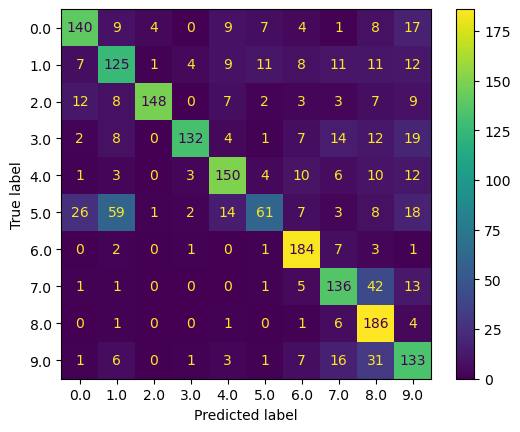

In [18]:
print("Classification Metrics:")
print(f"Accuracy: {classification_accuracy}")
print(f"Precision: {classification_precision}")
print(f"Recall: {classification_recall}")
print(f"F1-Score: {classification_f1}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
confusion_matrix_display.plot()
plt.show()

In [19]:
feature_extractor = tf.keras.Model(inputs=model_m1.input, outputs=model_m1.layers[-4].output)

In [20]:
feature_extractor.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,225,856 (16.12 MB)

 Trainable params: 2,700,352 (10.30 MB)

 Non-trainable params: 1,525,504 (5.82 MB)

In [21]:
start_time = time.time()
# Extract features from the training and test sets
x_train_features = feature_extractor.predict(x_train)
x_test_features = feature_extractor.predict(x_test)

feature_extraction_time = time.time() - start_time

250/250 ━━━━━━━━━━━━━━━━━━━━ 43s 169ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step


In [22]:
#Flatten the features for the SVM
x_train_features_flat = x_train_features.reshape(x_train_features.shape[0], -1)
x_test_features_flat = x_test_features.reshape(x_test_features.shape[0], -1)
print(f"x_train_features_flat shape: {x_train_features_flat.shape}")
print(f"x_test_features_flat shape: {x_test_features_flat.shape}")

# Ensure labels are in the correct format
y_train_labels = y_train
y_test_labels = y_test

print(f"x_train_features_flat shape: {y_train_labels.shape}")
print(f"x_test_features_flat shape: {y_test_labels.shape}")

x_train_features_flat shape: (7990, 256)
x_test_features_flat shape: (1990, 256)
x_train_features_flat shape: (7990,)
x_test_features_flat shape: (1990,)


In [23]:
# Train the SVM classifier
svm_model = make_pipeline(StandardScaler(), SVC(probability=True))

In [24]:
# One-vs-One (OvO) SVM
start_time = time.time()
ovo_svm = OneVsOneClassifier(svm_model)
ovo_svm.fit(x_train_features_flat, y_train_labels)
ovo_train_time = time.time() - start_time

# One-vs-All (OvA) SVM
start_time = time.time()
ova_svm = OneVsRestClassifier(svm_model)
ova_svm.fit(x_train_features_flat, y_train_labels)
ova_train_time = time.time() - start_time

In [25]:
#Evaluate One-vs-One (OvO) SVM
start_time = time.time()
ovo_predictions = ovo_svm.predict(x_test_features_flat)
ovo_test_time = time.time() - start_time
ovo_accuracy = accuracy_score(y_test_labels, ovo_predictions)
print(f"OvO SVM accuracy: {ovo_accuracy}")

# Evaluate One-vs-All (OvA) SVM
start_time = time.time()
ova_predictions = ova_svm.predict(x_test_features_flat)
ova_test_time = time.time() - start_time
ova_accuracy = accuracy_score(y_test_labels, ova_predictions)
print(f"OvA SVM accuracy: {ova_accuracy}")


OvO SVM accuracy: 0.7301507537688442
OvA SVM accuracy: 0.7386934673366834


OvO SVM Results:
Classification Metrics:
Accuracy: 0.7301507537688442
Precision: 0.7357396448306587
Recall: 0.7301507537688442
F1-Score: 0.7316113801773059
Confusion Matrix:
[[145  10   6   2  10  22   0   0   1   3]
 [  7 117   3  15   9  31   2   3   4   8]
 [  8   7 156   5   5  13   0   2   1   2]
 [  3   8   0 161   4   1   4   6   4   8]
 [  1   2   1  12 152  13   4   5   2   7]
 [ 17  46   2  11  10 107   1   1   1   3]
 [  0   5   0   7   1   2 176   6   1   1]
 [  1  10   0   2   8   2   2 145  17  12]
 [  0   2   0   2   4   0   1  23 160   7]
 [  1   9   0   7   7   5   4  19  13 134]]


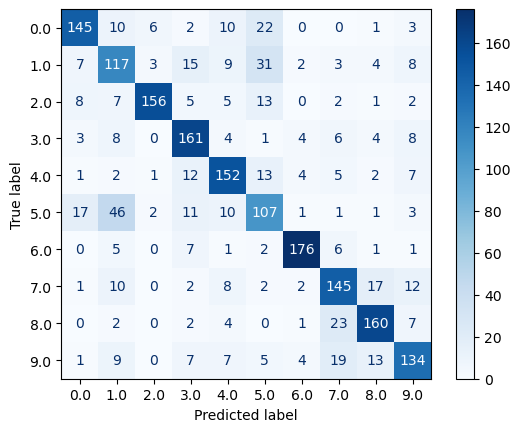

OvA SVM Results:
Classification Metrics:
Accuracy: 0.7386934673366834
Precision: 0.7388395743565154
Recall: 0.7386934673366834
F1-Score: 0.737306765396057
Confusion Matrix:
[[149  10   7   1   9  13   0   1   1   8]
 [  9 122   2  14   6  26   3   3   6   8]
 [  9   5 163   1   6   9   1   1   1   3]
 [  2   8   0 165   3   1   3   6   3   8]
 [  2   2   0  11 157  10   3   4   4   6]
 [ 22  47   4   7  13  94   0   0   3   9]
 [  0   3   0   8   2   1 176   7   0   2]
 [  1   7   0   3   5   1   3 148  20  11]
 [  0   1   1   1   2   0   1  24 163   6]
 [  1   7   1   7   7   4   5  18  16 133]]


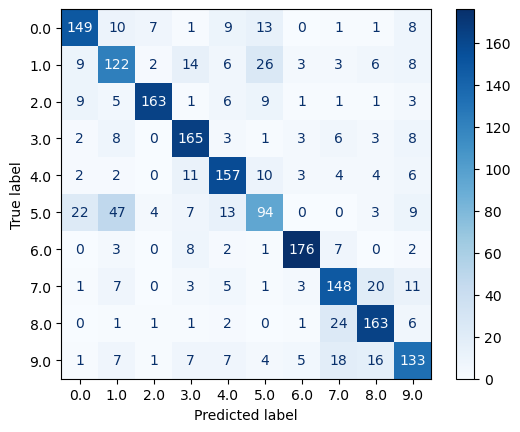

In [26]:
# Function to print classification metrics
def print_classification_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("Classification Metrics:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))
    confusion_matrix_display.plot(cmap=plt.cm.Blues)
    plt.show()

# Evaluate One-vs-One (OvO) SVM
ovo_predictions = ovo_svm.predict(x_test_features_flat)
print("OvO SVM Results:")
print_classification_metrics(y_test_labels, ovo_predictions)

# Evaluate One-vs-All (OvA) SVM
ova_predictions = ova_svm.predict(x_test_features_flat)
print("OvA SVM Results:")
print_classification_metrics(y_test_labels, ova_predictions)